# Figures
> (For the first draft, loading data generated by 'benchmarks' folder notebooks)

Last modified October 28, 2023

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import sys
from aptr.simulation_new import _exact_coverage_curve, oor_distance
from aptr.database import RnaDB

from scipy.stats import pearsonr, spearmanr

In [3]:
# Load tables:

amplicon_bias = pd.read_table("../../data/figures/amplicon_bias_term.tsv", index_col=None)
poisson_gaussian = pd.read_table("../../data/figures/poisson_vs_gaussian_scaling.tsv", index_col=None)
scaling_matrix1 = pd.read_table("../../data/figures/scaling_experiment_matrix.tsv", index_col=None)
scaling_matrix2 = pd.read_table("../../data/figures/scaling_experiment_matrix2.tsv", index_col=None)

/tmp/ipykernel_3934605/3687548721.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("viridis", len(scaling_factors))
/tmp/ipykernel_3934605/3687548721.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(f["n_reads"], f["ptr_score"], label=f"1E{scaling_factor}", c=colors(i))


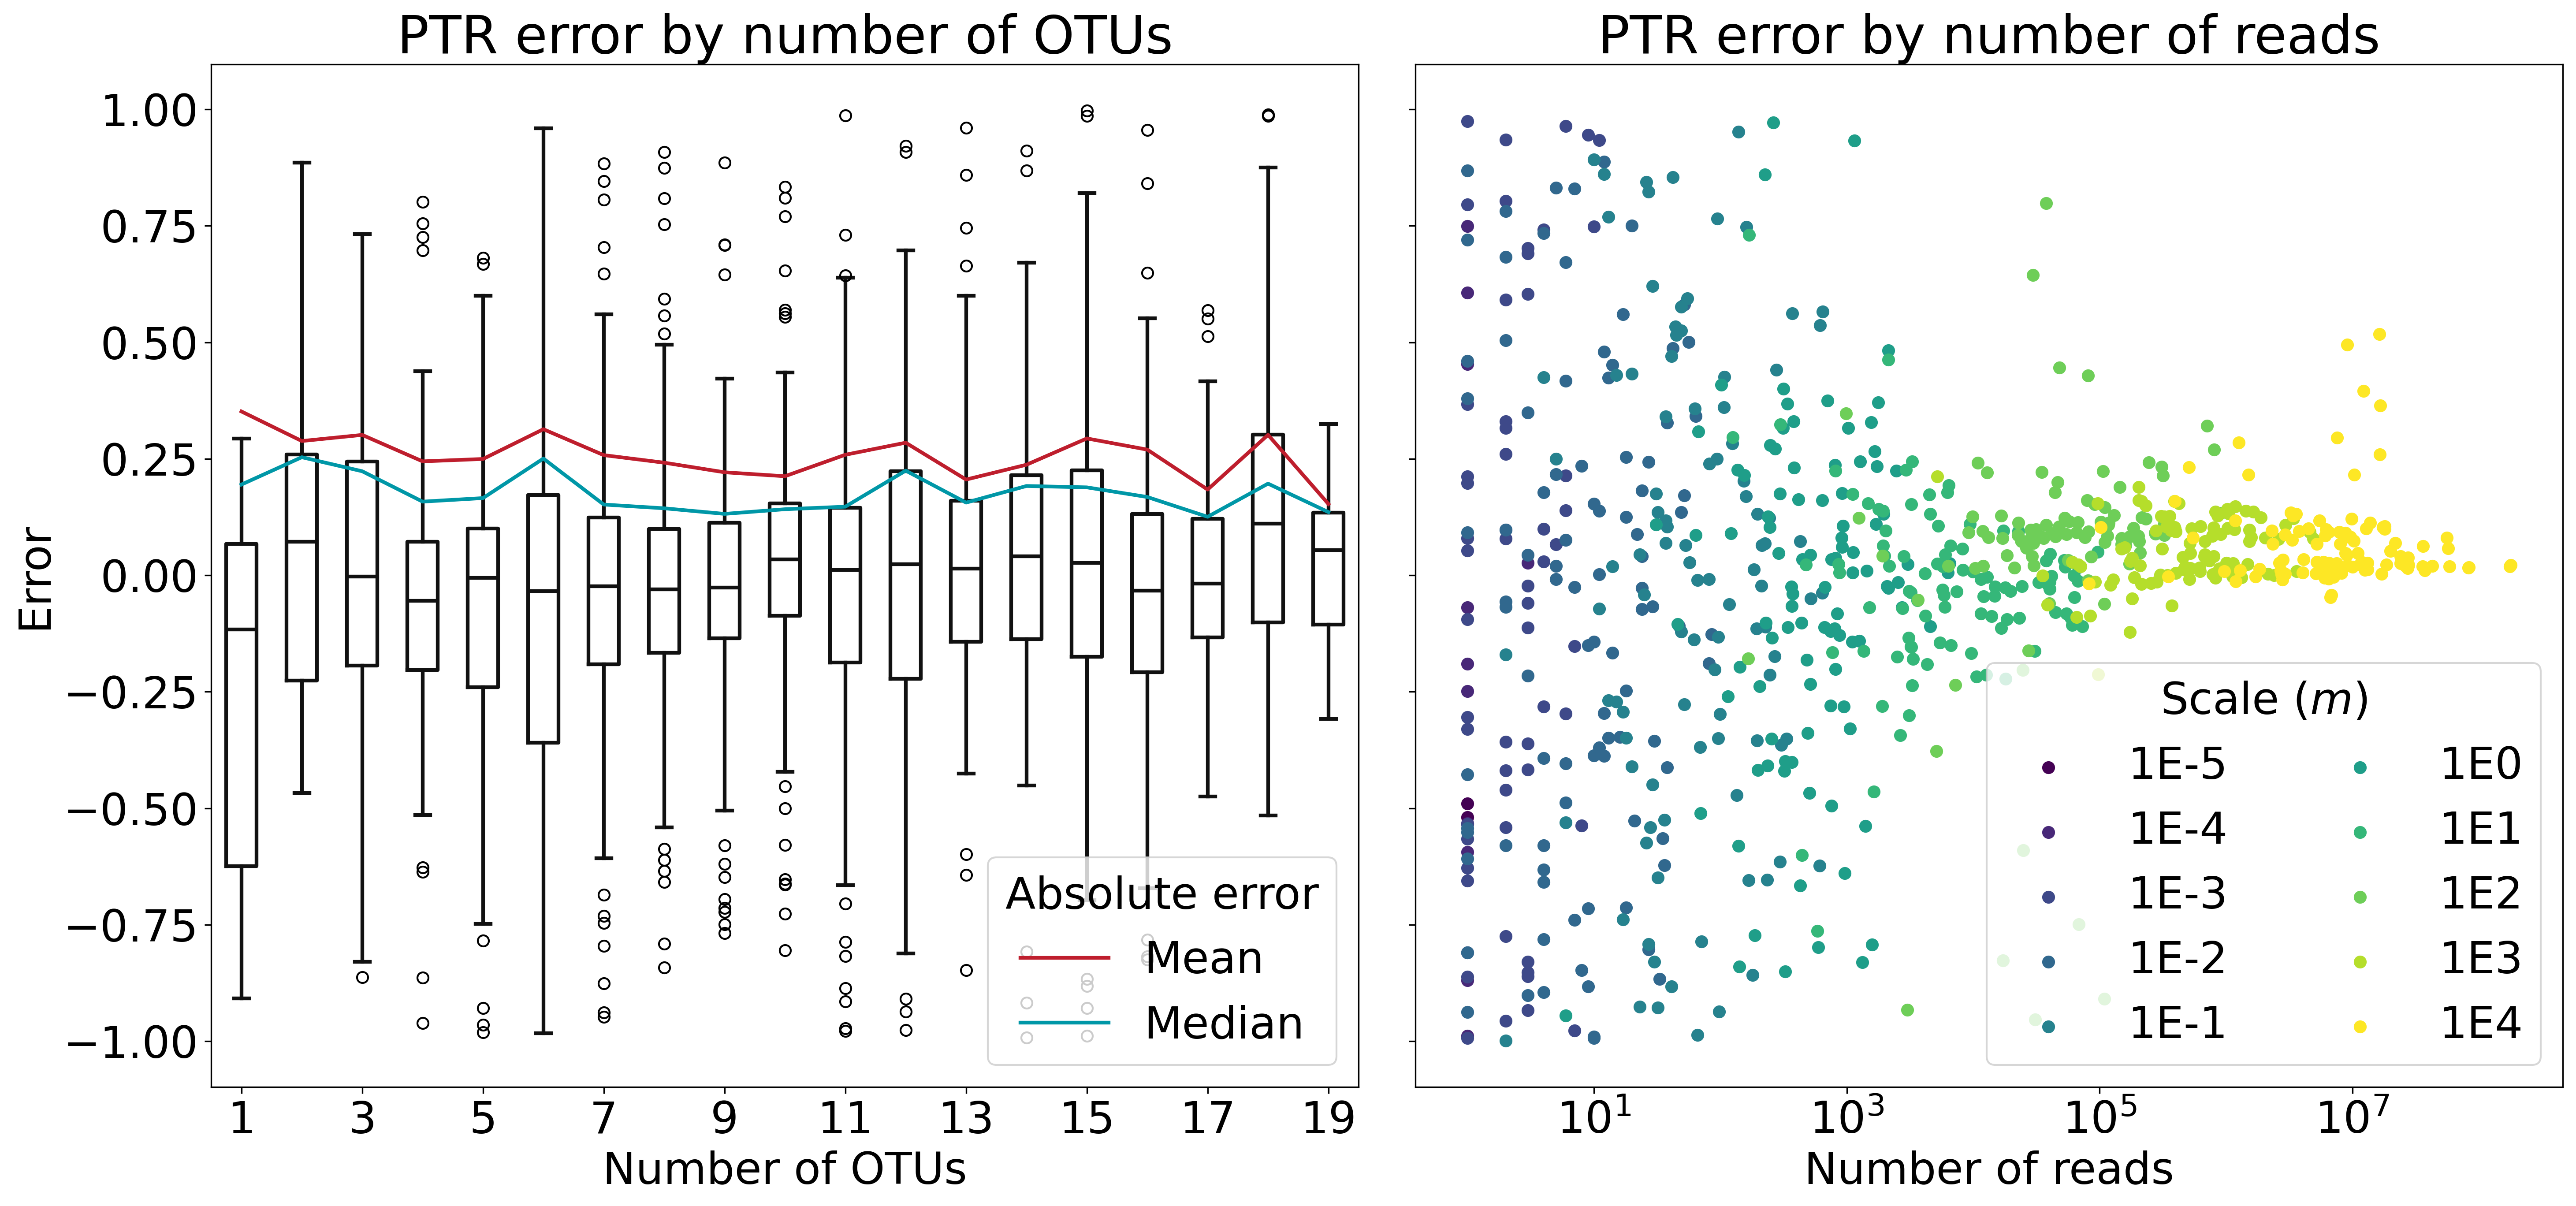

In [4]:
# Combine figures 2 and 3 into a single plot:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Fig 1
ax1 = scaling_matrix1.boxplot(by="n_genomes", column="ptr_score", ax=ax1, grid=False)

# Make boxplots thicker and #111111
for i, artist in enumerate(ax1.get_children()):
    if isinstance(artist, plt.Line2D):
        artist.set_color("#111111")
        artist.set_linewidth(2)

# Draw error on same figure with different y axis
g = scaling_matrix1[["n_genomes", "ptr_score"]].abs().groupby("n_genomes")["ptr_score"]
ax1.plot(np.arange(1, 20), g.mean(), c="#BE1E2D", lw=2, label="Mean")
ax1.plot(np.arange(1, 20), g.median(), c="#0097A7", lw=2, label="Median")
ax1.set_ylabel("Error")
ax1.set_xlabel("Number of OTUs")
ax1.set_title("PTR error by number of OTUs")
ax1.set_xticks(np.arange(1, 20, 2), np.arange(1, 20, 2))
ax1.legend(title="Absolute error", loc="lower right")

# Fig 3
scaling_factors = scaling_matrix2["scaling"].unique()
colors = cm.get_cmap("viridis", len(scaling_factors))

for i, scaling_factor in enumerate(scaling_factors):
    f = scaling_matrix2[scaling_matrix2["scaling"] == scaling_factor]
    ax2.scatter(f["n_reads"], f["ptr_score"], label=f"1E{scaling_factor}", c=colors(i))

ax2.set_xscale("log")
ax2.set_xlabel("Number of reads")
# ax2.set_ylabel("Error")
ax2.set_title("PTR error by number of reads")
ax2.legend(title="Scale ($m$)", ncol=2, loc="lower right")  # , fontsize=16, title_fontsize=16)

fig.suptitle("")
plt.tight_layout()
plt.show()

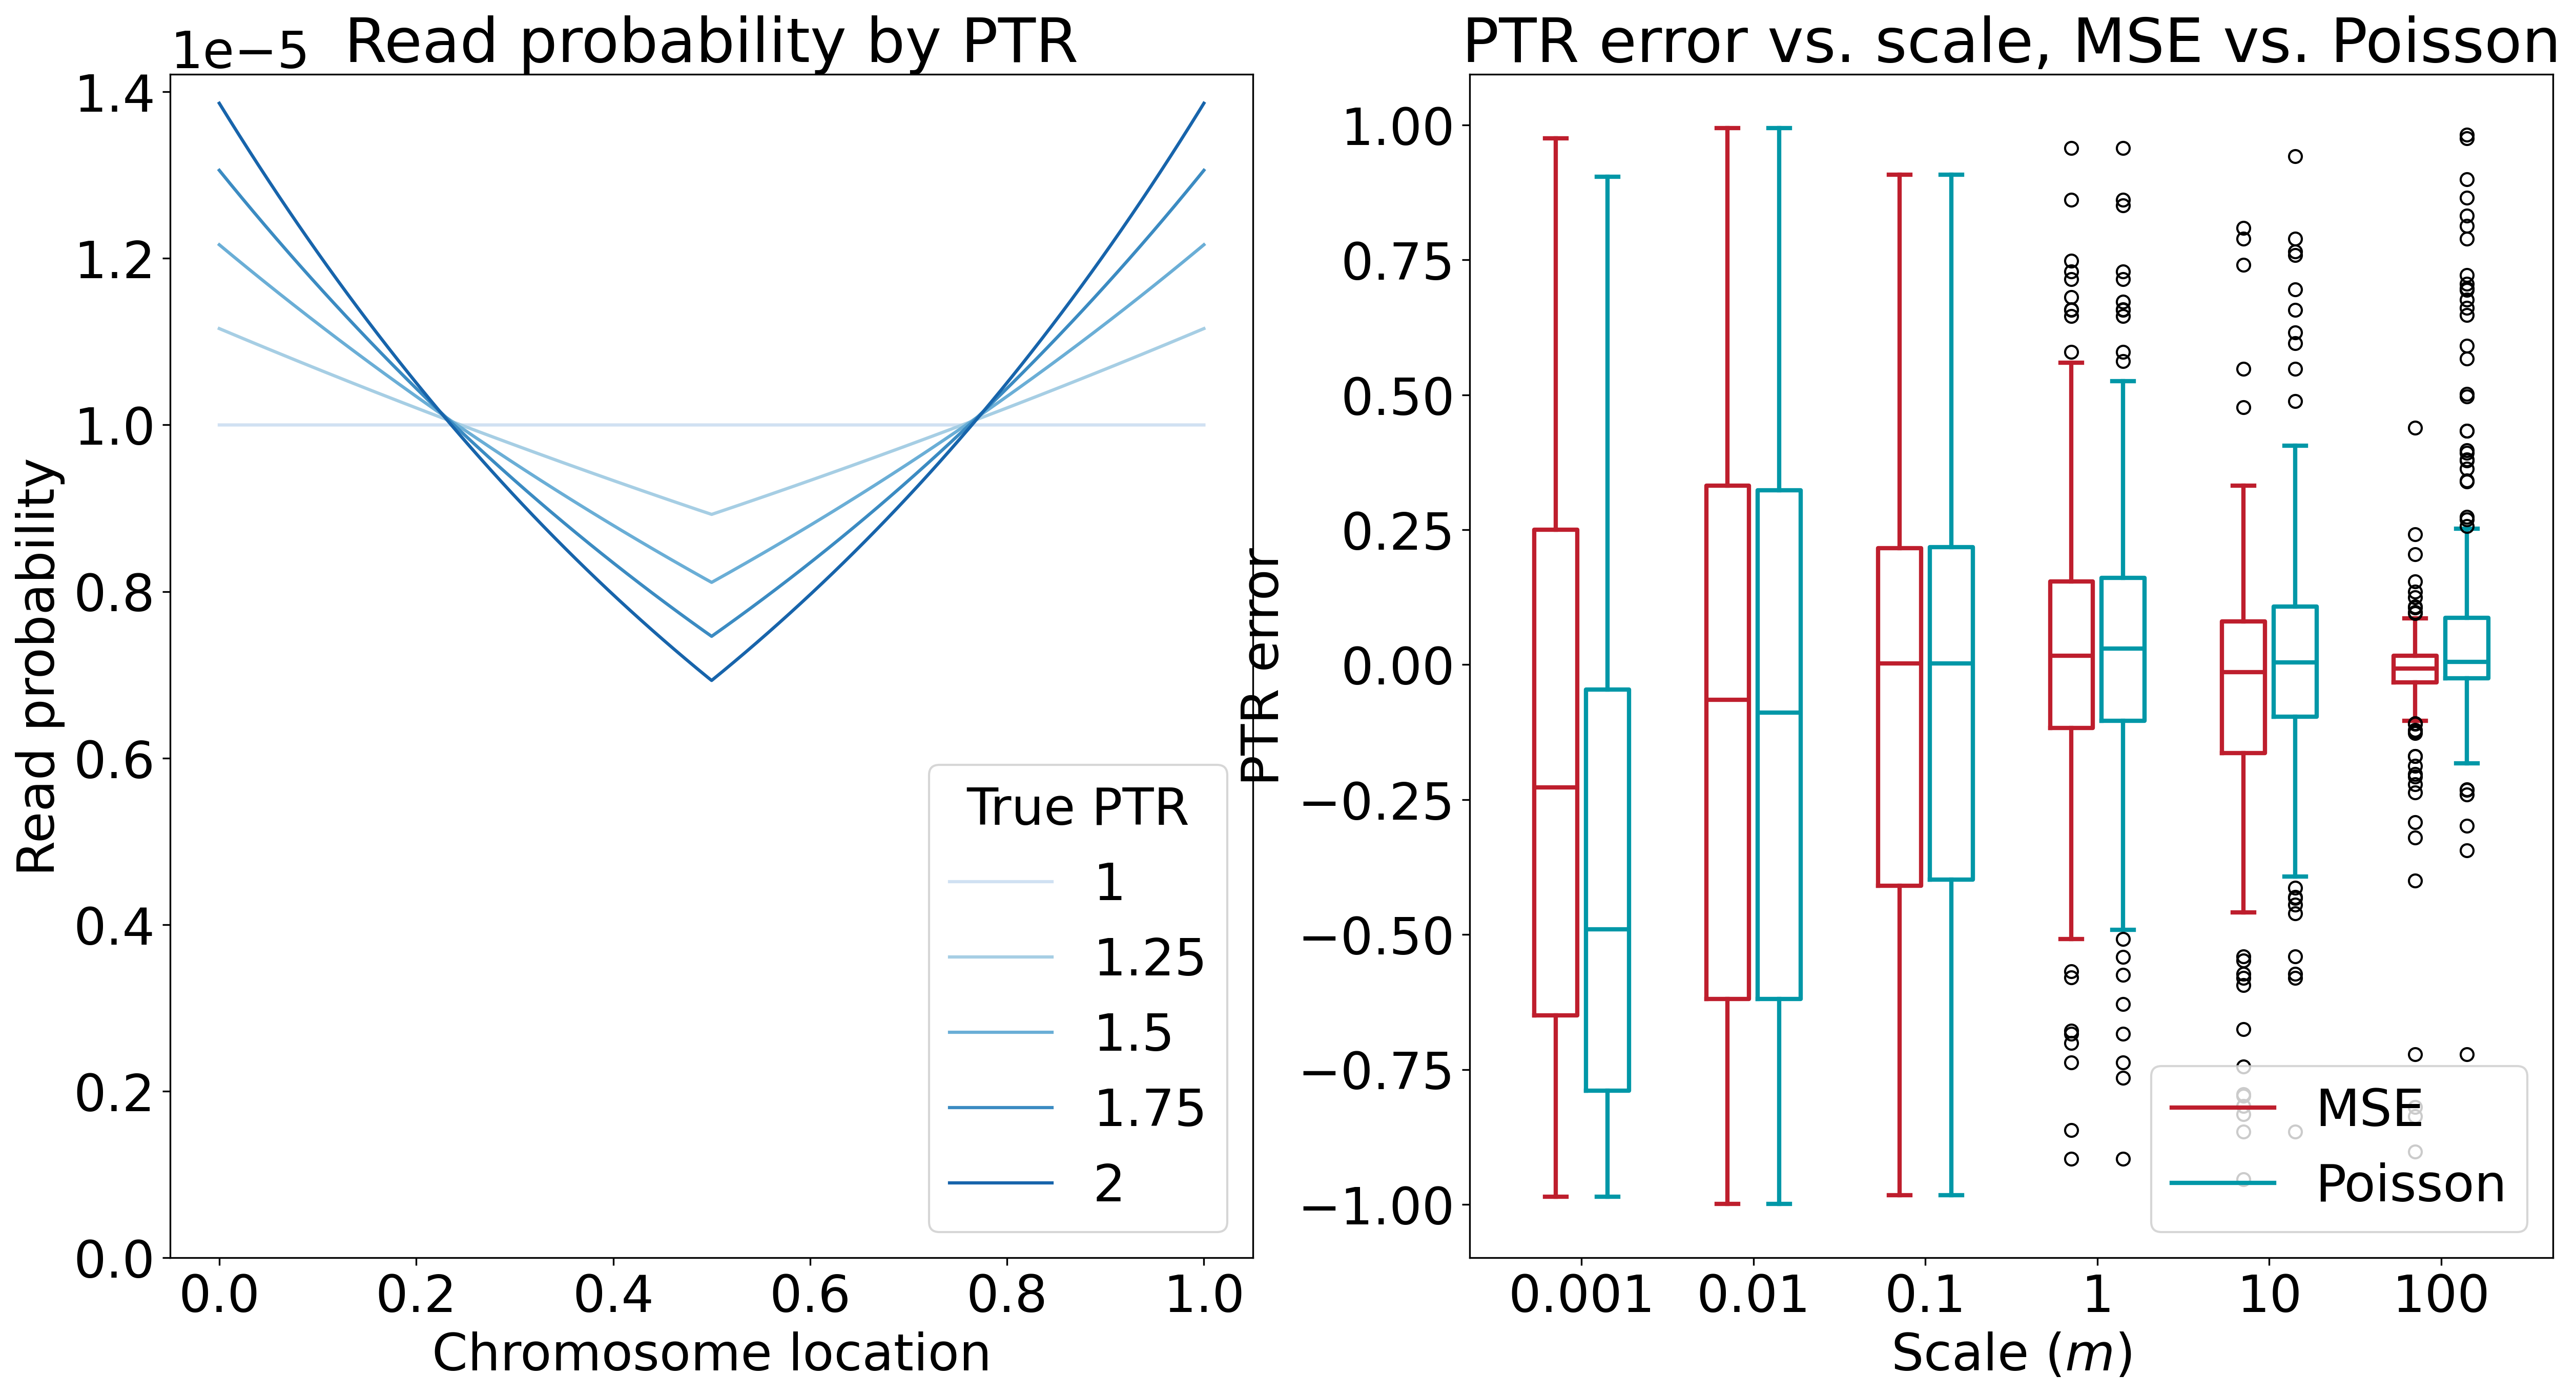

In [5]:
# Combine figure 4 and 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Figure 1
x = np.linspace(0, 1, 100000)
dists = oor_distance(x)
colors = plt.cm.Blues(np.linspace(0.2, 0.8, 5))

# Shades of blue
for ptr, color in zip([1, 1.25, 1.5, 1.75, 2], colors):
    y = _exact_coverage_curve(log_ptr=np.log(ptr), distances=dists)
    y /= np.sum(y)
    ax1.plot(x, y[0, :], label=ptr, color=color)
ax1.set_ylim(0, ax1.get_ylim()[1])
ax1.set_xlabel("Chromosome location")
ax1.set_ylabel("Read probability")
ax1.set_title("Read probability by PTR")
ax1.legend(title="True PTR", loc="lower right")

# Figure 4
losses = poisson_gaussian["loss_fn"].unique()
for_boxplot_mse = poisson_gaussian[poisson_gaussian["loss_fn"] == losses[0]]
for_boxplot_poisson = poisson_gaussian[poisson_gaussian["loss_fn"] == losses[1]]
x1 = [for_boxplot_mse[for_boxplot_mse["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_poisson[for_boxplot_poisson["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = ax2.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = ax2.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
ax2.set_xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
ax2.set_xlabel("Scale ($m$)")
ax2.set_ylabel("PTR error")
ax2.set_title("PTR error vs. scale, MSE vs. Poisson")

# Change colors for medians
for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
    for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
        for x in b[prop]:
            x.set(color=c, linewidth=2)

ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ["MSE", "Poisson"], loc="lower right")

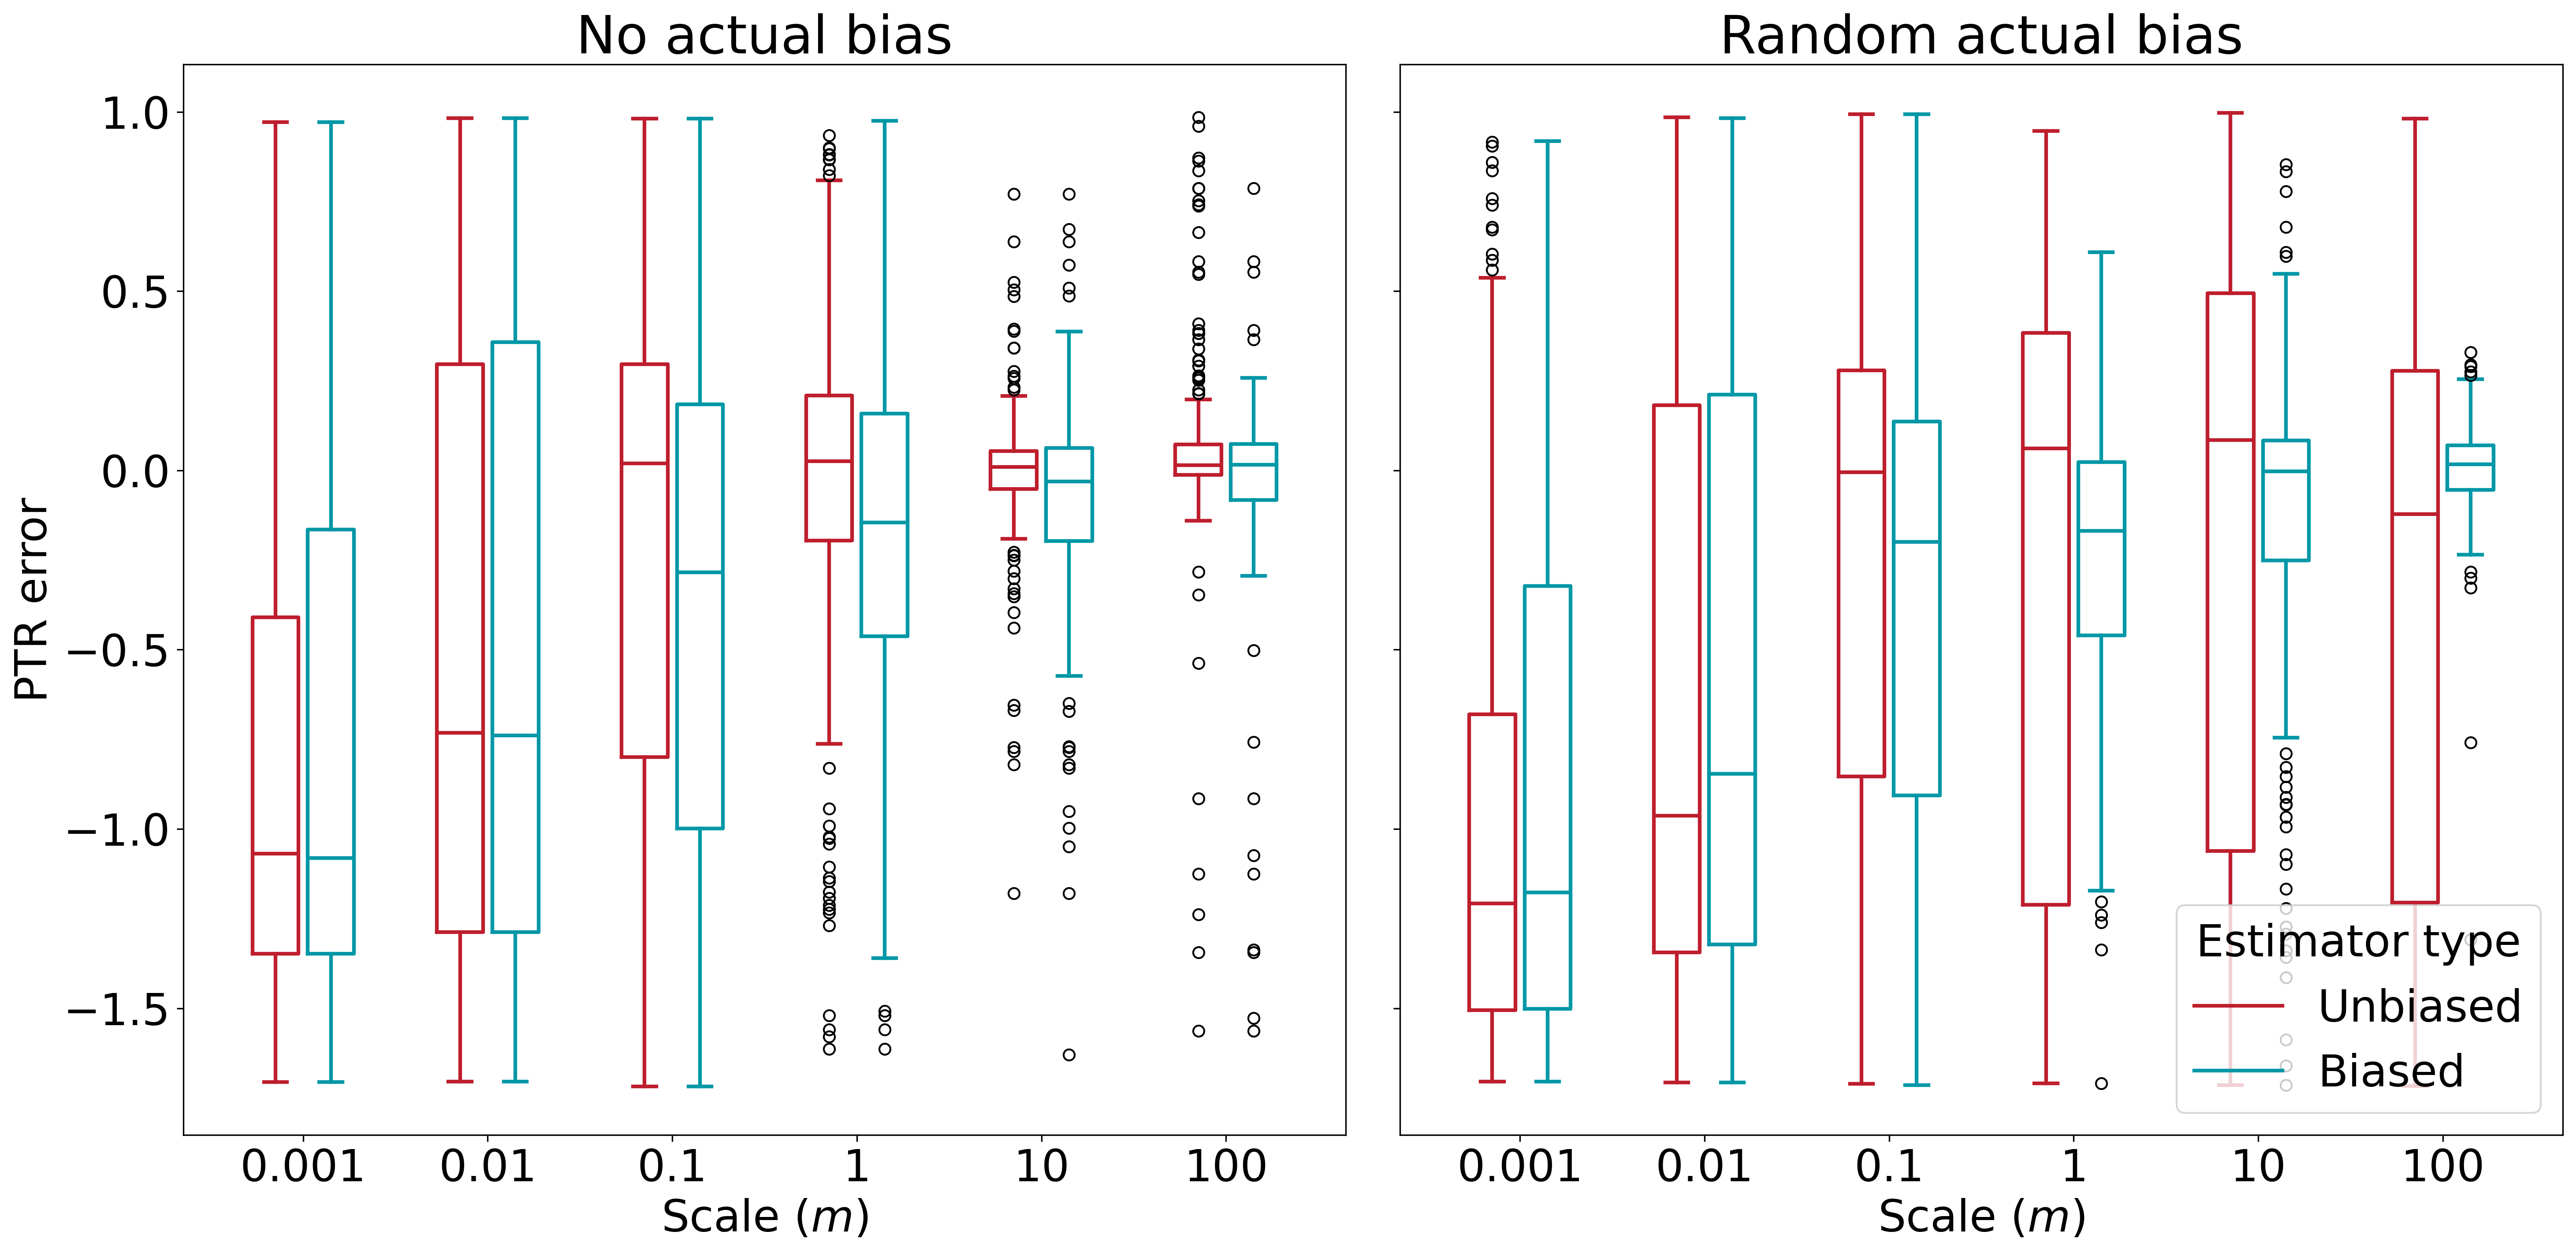

In [6]:
# Figures 5 and 6

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Make data
for ax, simulation_bias in zip((ax1, ax2), [False, True]):
    results_filtered = amplicon_bias[amplicon_bias["simulation_bias"] == simulation_bias]
    for_boxplot_unbiased = results_filtered[results_filtered["model_bias"] == False]
    for_boxplot_bias = results_filtered[results_filtered["model_bias"] == True]
    x1 = [for_boxplot_unbiased[for_boxplot_unbiased["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
    x2 = [for_boxplot_bias[for_boxplot_bias["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

    # Plot
    bp1 = ax.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
    bp2 = ax.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
    ax.set_xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
    ax.set_xlabel("Scale ($m$)")

    # Change colors for medians
    for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
        for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
            for x in b[prop]:
                x.set(color=c, linewidth=2)

# Only 1 ax:
ax1.set_ylabel("PTR error")
ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Unbiased", "Biased"], loc="lower right", title="Estimator type")

# Titles:
ax1.set_title("No actual bias")
ax2.set_title("Random actual bias")

# fig.suptitle("PTR error vs. scale, by estimator bias")
plt.tight_layout()
plt.show()

(13, 10) (13, 10) (13, 10)
(20, 10) (20, 10) (20, 10)
(20, 10) (20, 10) (20, 10)
                 1_0       1_1       1_2       1_3       1_4       1_5  \
Unnamed: 0                                                               
383372.6    0.005461 -0.015711  0.099989       NaN -0.019853  0.042111   
818.23           NaN -0.188725 -0.051863  0.000796  0.037460 -0.053356   
267747.3    0.470207  0.493239       NaN -0.226975  0.459027       NaN   
498761.4         NaN       NaN  0.061392  0.002875 -0.091998       NaN   
1262449.8        NaN       NaN -0.039202 -0.036114  0.011563       NaN   
759620.6   -0.107434       NaN       NaN  0.104908       NaN -0.026075   
435590.9         NaN  0.036754       NaN -0.007216 -0.002321 -0.007721   
37659.3          NaN  0.055779 -0.105364       NaN -0.028277       NaN   
592031.3         NaN       NaN       NaN       NaN -0.051571       NaN   
743721.3   -0.051792  0.031575  0.022738 -0.032306       NaN  0.209334   
759620.7   -0.053851       NaN 

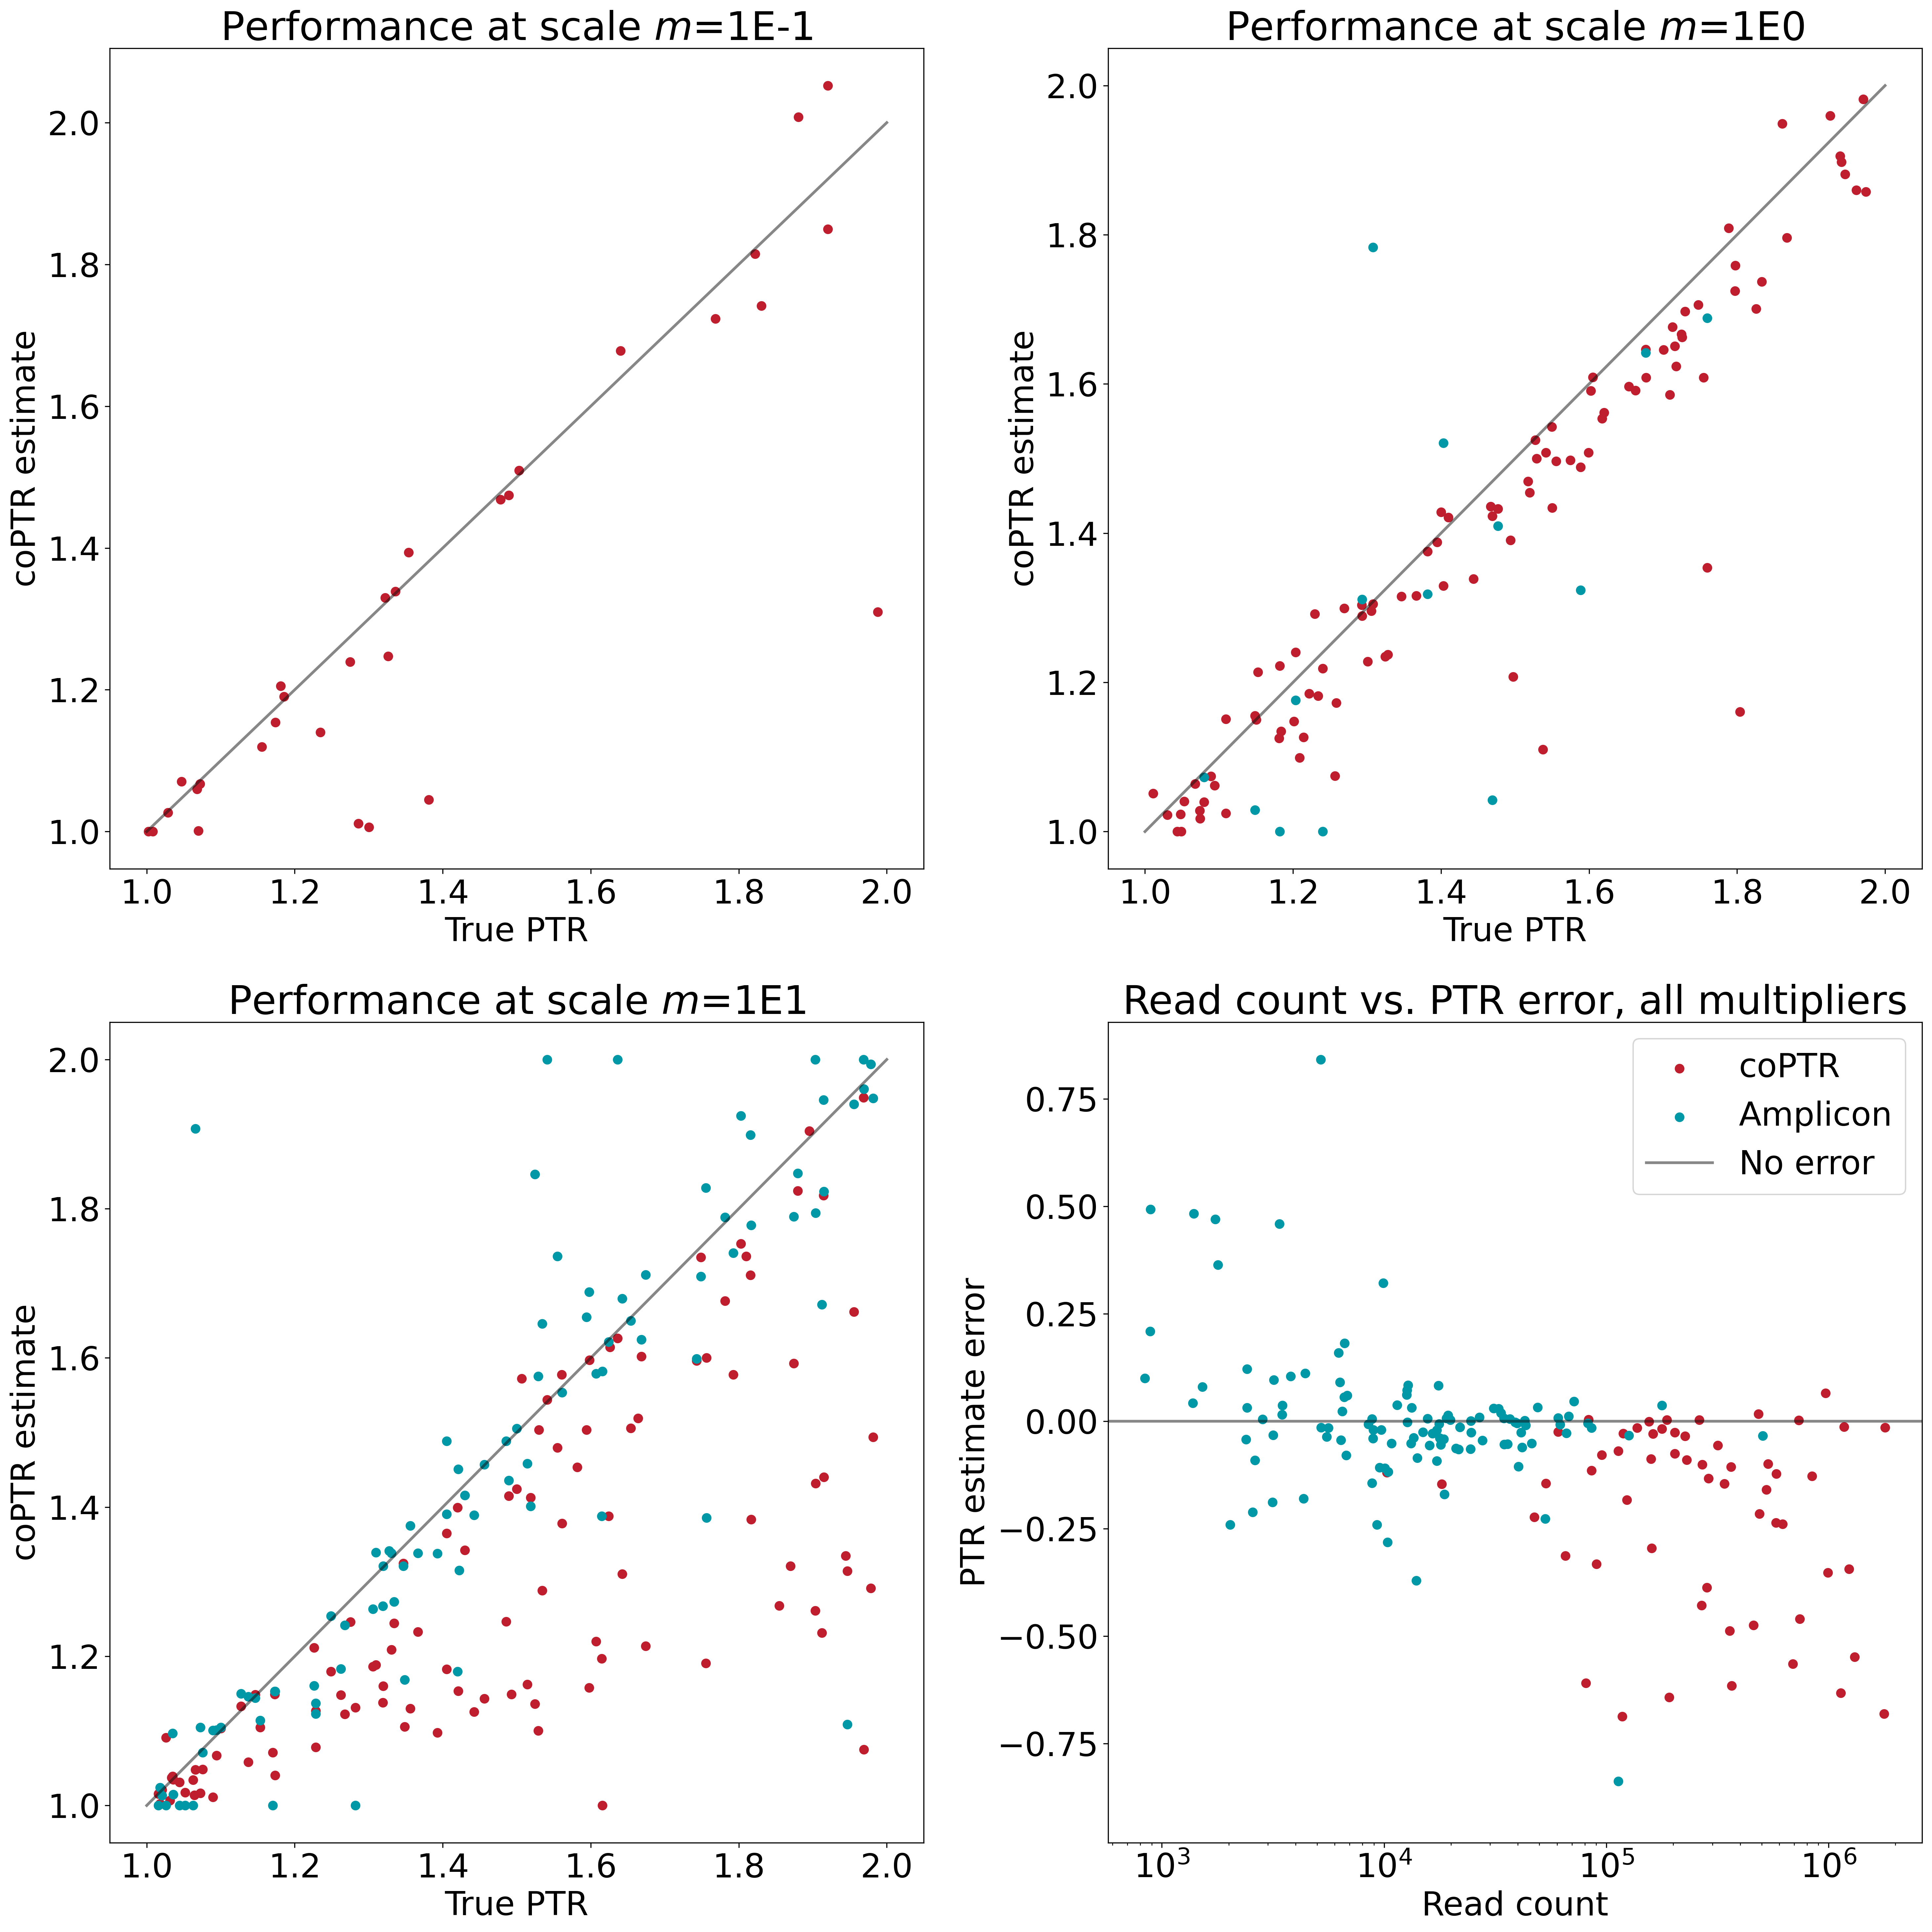

In [7]:
# Load PTR data, coPTR estimates, and aPTR estimates and compare

dd = "../../experiments/simulated/february2023"
MAX_MULT = 2
MIN_MULT = -1

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# First 3 scatterplots
for multiplier, ax in zip(range(MIN_MULT, MAX_MULT, 1), [axs[0, 0], axs[0, 1], axs[1, 0]]):
    true_ptrs = pd.read_table(f"{dd}/log2_ptrs_1E{multiplier}.tsv", dtype={0: str})
    true_ptrs = true_ptrs.set_index(true_ptrs.columns[0])
    true_ptrs = 2**true_ptrs

    coptr_estimate = pd.read_csv(f"{dd}/coptr/coptr_1E{multiplier}.csv", dtype={0: str})
    coptr_estimate = coptr_estimate.set_index(coptr_estimate.columns[0])
    coptr_estimate = 2**coptr_estimate

    aptr_estimate = pd.read_table(f"{dd}/fastq_1E{multiplier}/aptr_results/inferred_ptrs.tsv", dtype={0: str})
    aptr_estimate = aptr_estimate.set_index(aptr_estimate.columns[0])

    # Reindex to shared OTUs
    true_ptrs = true_ptrs.reindex(set(coptr_estimate.index) & set(aptr_estimate.index))
    coptr_estimate = coptr_estimate.loc[true_ptrs.index]
    aptr_estimate = aptr_estimate.loc[true_ptrs.index]

    print(true_ptrs.shape, coptr_estimate.shape, aptr_estimate.shape)

    # Non-NA for all
    ax.plot([1, 2], [1, 2], c="#111111", alpha=0.5, lw=2)
    ax.scatter(true_ptrs.values, coptr_estimate.values, c="#BE1E2D")
    ax.scatter(true_ptrs.values, aptr_estimate.values, c="#0097A7")
    ax.set_xlabel("True PTR")
    ax.set_ylabel("coPTR estimate")
    ax.set_title(f"Performance at scale $m$=1E{multiplier}")

# Reads scatterplot
coptr_counts_all = pd.DataFrame()
coptr_errors_all = pd.DataFrame()
aptr_counts_all = pd.DataFrame()
aptr_errors_all = pd.DataFrame()

for multiplier in range(MIN_MULT + 2, MAX_MULT, 1):
    coptr_estimate = pd.read_csv(f"{dd}/coptr/coptr_all_1E{multiplier}.csv", dtype={0: str})
    coptr_counts = pd.read_csv(f"{dd}/coptr/coptr_counts_1E{multiplier}.csv", dtype={0: str})
    aptr_estimate = pd.read_table(f"{dd}/fastq_1E{multiplier}/aptr_results/all_inferred_ptrs.tsv", dtype={0: str})
    otus = pd.read_table(f"{dd}/fastq_1E{multiplier}/aptr_results/filtered_otu_table.tsv", dtype={0: str})
    true_ptrs = pd.read_table(f"{dd}/log2_ptrs_1E{multiplier}.tsv", dtype={0: str})

    for df in [coptr_estimate, coptr_counts, aptr_estimate, otus, true_ptrs]:
        df.set_index(df.columns[0], inplace=True)

    coptr_estimate = 2**coptr_estimate
    true_ptrs = 2**true_ptrs

    # Rename columns for coPTR dfs
    coptr_estimate.columns = coptr_counts.columns = aptr_estimate.columns = otus.columns = true_ptrs.columns = [
        f"{multiplier}_{x}" for x in range(10)
    ]

    # Get errors
    idx1 = set(coptr_estimate.index) & set(true_ptrs.index)
    coptr_errors = coptr_estimate.reindex(idx1) - true_ptrs.reindex(idx1)
    idx2 = set(aptr_estimate.index) & set(true_ptrs.index)
    aptr_errors = aptr_estimate.reindex(idx2) - true_ptrs.reindex(idx2)
    print(aptr_errors)

    # Getting read counts for aPTR is tricky - we need to sum over the OTUs
    # with open(f"{dd}/fastq_1E{multiplier}/aptr_results/db.pkl", "rb") as f:
    # db = pickle.load(f)
    db = RnaDB()  # Workaround
    aptr_counts = pd.DataFrame(0, index=aptr_errors.index, columns=aptr_errors.columns)
    for otu in otus.index:
        genomes = db.find_genomes_by_md5(otu)

        # Can add whole rows at once
        for genome in genomes:
            aptr_counts.loc[genome] += otus.loc[otu]

    # Append all as columns
    coptr_counts_all = pd.concat([coptr_counts_all, coptr_counts], axis=1)
    coptr_errors_all = pd.concat([coptr_errors_all, coptr_errors], axis=1)
    aptr_counts_all = pd.concat([aptr_counts_all, aptr_counts], axis=1)
    aptr_errors_all = pd.concat([aptr_errors_all, aptr_errors], axis=1)

# Matplotlib stuff is straightforward
axs[1, 1].scatter(coptr_counts_all, coptr_errors_all, c="#BE1E2D", label="coPTR")
axs[1, 1].scatter(aptr_counts_all, aptr_errors_all, c="#0097A7", label="Amplicon")
axs[1, 1].axhline(0, c="#111111", alpha=0.5, label="No error", lw=2)
axs[1, 1].set_xlabel("Read count")
axs[1, 1].set_ylabel("PTR estimate error")
axs[1, 1].set_xscale("log")
axs[1, 1].set_title("Read count vs. PTR error, all multipliers")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/phil/DATA/diabimmune/wgs_aptr/coptr_out/coptr_log2_ptrs.csv'

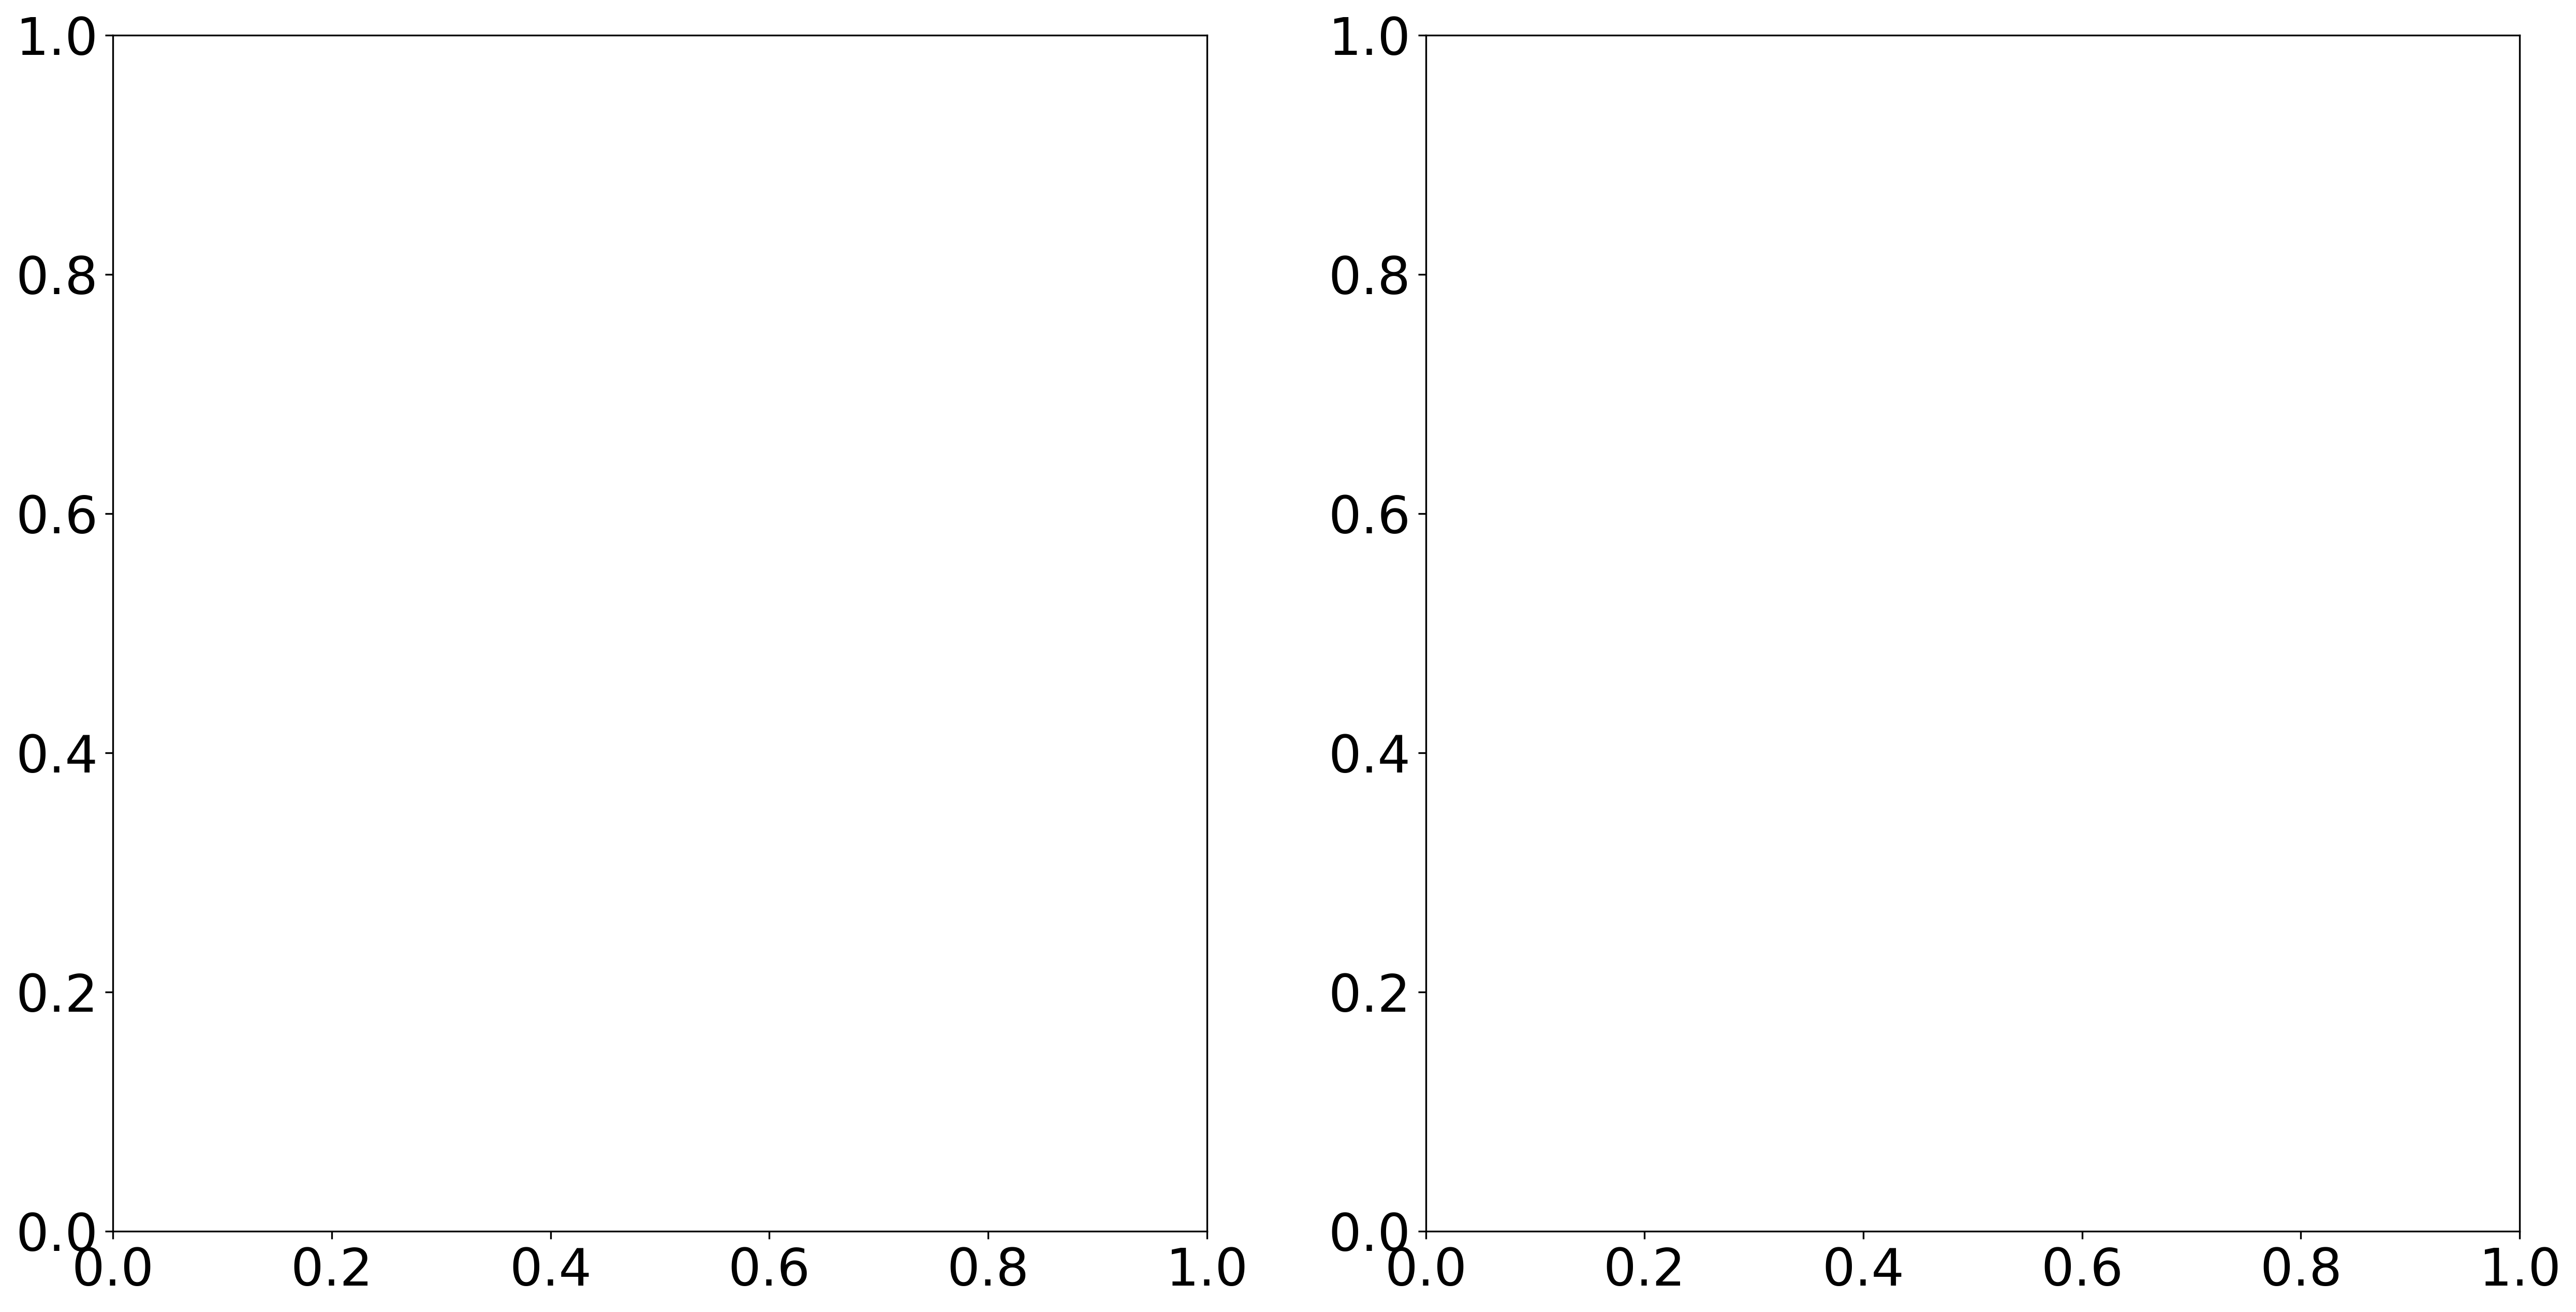

In [8]:
# DIABIMMUNE figures (more complicated)

fig = plt.subplots(1, 2, figsize=(20, 10))

# Read outputs
coptr_out = pd.read_csv("/home/phil/DATA/diabimmune/wgs_aptr/coptr_out/coptr_log2_ptrs.csv", dtype={0: str})
coptr_out = coptr_out.set_index(coptr_out.columns[0])
coptr_out = 2**coptr_out

aptr_out = pd.read_table(
    "../../experiments/diabimmune/16s_shared/aptr_c20891fa-743b-46f7-a6a4-61ce28849342/inferred_ptrs.tsv",
    dtype={0: str},
)
aptr_out = aptr_out.set_index(aptr_out.columns[0])

# Need to translate sample IDs
wgs_to_rna = dict(zip(diabimmune_both["gid_wgs"], diabimmune_both["gid_16s"]))
coptr_out.columns = [wgs_to_rna[col] for col in coptr_out.columns]
aptr_out.columns = [name.split("_")[0] for name in aptr_out.columns]

# Overlaps between values
aptr_out = aptr_out.loc[:, aptr_out.sum(axis=0) > 0]
coptr_out = coptr_out.loc[:, coptr_out.sum(axis=0) > 0]

mask1 = aptr_out > 0
mask2 = coptr_out > 0
mask = mask1 & mask2

# 73 whole overlaps! Amazing
print(mask.sum().sum())

# Turn into vectors of values and get correlation coefficients

aptr_matched = aptr_out[mask].values.flatten()
aptr_matched = aptr_matched[~np.isnan(aptr_matched)]

coptr_matched = coptr_out[mask].values.flatten()
coptr_matched = coptr_matched[~np.isnan(coptr_matched)]

# Pearson's R


pr, _ = pearsonr(aptr_matched, coptr_matched)
sr, _ = spearmanr(aptr_matched, coptr_matched)

plt.scatter(aptr_matched, coptr_matched, c="#0097A7")
plt.xlabel("Amplicon PTR estimate")
plt.ylabel("coPTR estimate")
plt.title(f"Amplicon PTR vs coPTR estimates on DIABIMMUNE dataset\n(Pearson's R={pr:.2f}, Spearman's R={sr:.2f})")